<div align="center">

# Citation Network Prediction  
### Gammafest IPB 2025 – Data Science Competition  

## Team <span style="color:#4b6cb7;">Wakilin EDM</span> - Telkom University  

<table>
  <tr>
    <th>Member Name</th>
  </tr>
  <tr>
    <td>Ahmad Fauzi</td>
  </tr>
  <tr>
    <td>Alvaro Cleosanda</td>
  </tr>
  <tr>
    <td>I Gede Made Ari Ananta</td>
  </tr>
</table>

</div>
<br>

---

## 📝 Project Summary

In this notebook, we present a complete machine learning pipeline to predict whether a scientific paper cites another. We use feature engineering, preprocessing, and **CatBoost** classification modeling. Our workflow includes:

- **Data Cleaning & Feature Preprocessing**: Managing missing values, dropping irrelevant features, scaling data, and addressing class imbalance using **SMOTE** and downsampling.
- **Modeling**: Training a **CatBoost** baseline model, evaluating it with **Matthews Correlation Coefficient (MCC)** and a confusion matrix.
- **Hyperparameter Tuning**: Applying **Optuna** for optimized parameter search to boost performance.
- **Final Prediction & Submission**: Making test predictions and exporting to submission format.

This pipeline emphasizes balanced learning and leverages modern tools for robust, high-performing models.

---

## 📖 Background Story

For centuries, the **Library of Elbaf** has preserved the world's knowledge—from ancient texts to modern research. Guarded by Biblo, the devoted keeper, the library has always supported scholars in their quest for truth.

Now, the system is failing. A group of Holy Knights—researchers with a legacy to build—arrive in search of references to support their work. But even Biblo cannot track the complex web of citations needed.

> Our mission: help Biblo restore this system using machine learning to uncover citation links and support research for generations to come.

---

## ⚔️ The Challenge

- Conventional recommendation engines fall short in scientific citation mapping.
- The citation relationship between papers is difficult to detect using simple heuristics.
- We must develop a model that predicts if one scientific paper cites another based on available data.

---

## 📊 Evaluation Metric

- **Metric:** Matthews Correlation Coefficient (MCC)  
  MCC is especially suitable for binary classification with imbalanced datasets.

---

## 📁 Dataset Overview

The dataset contains pairs of scientific papers along with metadata like title, abstract, year, and ID. Each row indicates a potential citation link between `paper` and `referenced_paper`.

### 📂 Files Provided:

- `papers_metadata.csv`: Metadata for each paper (ID, title, DOI, year, authors, etc.)
- `train.csv`: Training set with labeled citation pairs.
- `test.csv`: Test set with citation pairs to predict.
- `sample_submission.csv`: Template for submission format.
- **Paper Text Folder**: Contains full paper content in `.txt` files named by `paper_id`.

---

# 0. Import necessary libraries

In [ ]:
# ⚙️ Environment Setup
!pip install pandas numpy scikit-learn lightgbm xgboost catboost tqdm nltk matplotlib seaborn optuna

In [1]:
import pandas as pd
import numpy as np
import os
import re
import time
import gc
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import matthews_corrcoef, classification_report, roc_auc_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from scipy.sparse import hstack, csr_matrix, vstack
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import VotingClassifier
import re
import pickle
import optuna

In [2]:
# Set global configurations

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')
print("Downloading NLTK resources...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
print("Done downloading NLTK resources.")

Done downloading NLTK resources.


# 1. Load Datasets

In [3]:
# Load metadata
metadata_df = pd.read_csv('papers_metadata.csv')
print(f"Metadata loaded successfully. Shape: {metadata_df.shape[0]:,} rows, {metadata_df.shape[1]} columns")

# Load train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(f"Training data loaded. Shape: {train_df.shape[0]:,} rows, {train_df.shape[1]} columns")
print(f"Test data loaded. Shape: {test_df.shape[0]:,} rows, {test_df.shape[1]} columns")

Metadata loaded successfully. Shape: 4,354 rows, 9 columns
Training data loaded. Shape: 410,691 rows, 3 columns
Test data loaded. Shape: 336,021 rows, 3 columns


In [4]:
# Display class distribution
print("Class distribution in training data:")
print(train_df['is_referenced'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

Class distribution in training data:
is_referenced
0    98.95%
1     1.05%
Name: proportion, dtype: object


---

## **2. Preliminary Analysis**

### Initial Exploration & Cleaning

Before jumping into modeling, it's crucial to understand the characteristics of our dataset and ensure it's clean and consistent. Here's what we do in this step:

---

### Check Class Imbalance

We begin by checking the class distribution of the target variable `is_referenced`. This helps us prepare for modeling strategies like resampling or class weighting.

--- 

### Custom Text Preprocessing Function
Text fields like titles and abstracts can be noisy. To clean them up for NLP processing, we define a flexible preprocessing function using:

* Lowercasing
* Punctuation removal (excluding hyphens)
* Stopword filtering
* Optional stemming or lemmatization
* Optional digit and short word removal

In [5]:
# Calculate class imbalance for later use in modeling
pos_ratio = train_df['is_referenced'].mean()
neg_pos_ratio = (1 - pos_ratio) / pos_ratio
print(f"Negative to positive ratio: {neg_pos_ratio:.2f}")

Negative to positive ratio: 94.69


In [6]:
# Explore and clean metadata
print("Missing values in metadata:")
print(metadata_df.isnull().sum())

Missing values in metadata:
paper_id             0
doi                 34
title               46
publication_year     0
publication_date     0
cited_by_count       0
type                 0
authors             24
concepts             0
dtype: int64


In [7]:
# Clean metadata
metadata_df['title'] = metadata_df['title'].fillna('[No Title]')
metadata_df['authors'] = metadata_df['authors'].fillna('[Unknown Authors]')
metadata_df['doi'] = metadata_df['doi'].fillna('[No DOI]')
metadata_df['publication_year'] = metadata_df['publication_year'].fillna(0).astype(int)
metadata_df['cited_by_count'] = metadata_df['cited_by_count'].fillna(0).astype(int)
metadata_df['concepts'] = metadata_df['concepts'].fillna('[]')
metadata_df['type'] = metadata_df['type'].fillna('unknown')

In [8]:
# Check for duplicate papers

duplicate_papers = metadata_df['paper_id'].duplicated().sum()
print(f"Duplicate paper IDs: {duplicate_papers}")

Duplicate paper IDs: 0


In [9]:
# Create mapping for faster lookups
paper_id_to_idx = {paper_id: idx for idx, paper_id in enumerate(metadata_df['paper_id'])}
print("Paper ID to index mapping created.")

Paper ID to index mapping created.


In [10]:
# Define enhanced text preprocessing functions
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text,
                    use_stemming=False,
                    use_lemmatization=True,  # Changed default to True for better semantic preservation
                    remove_numbers=False,    # Changed to False to keep potentially important numbers
                    keep_short_words=True):  # Changed to True to maintain more information
    """
    Preprocess text by applying various NLP transformations
    """
    if not isinstance(text, str):
        return ''

    # Lowercase
    text = text.lower()

    # Remove punctuation but keep hyphens for compound words
    text = re.sub(r'[^\w\s-]', ' ', text)

    # Optionally remove numbers
    if remove_numbers:
        text = re.sub(r'\d+', ' ', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Filter and process tokens
    processed = []
    for word in tokens:
        # Skip stopwords
        if word in stop_words:
            continue
        
        # Optionally skip very short words
        if not keep_short_words and len(word) <= 2:
            continue

        # Apply stemming or lemmatization
        if use_stemming:
            word = stemmer.stem(word)
        elif use_lemmatization:
            word = lemmatizer.lemmatize(word)
        
        processed.append(word)

    return ' '.join(processed)

---

# **3. Data Preprocessing**

## 🔄 Summary of the Pipeline

A comprehensive walkthrough of our citation prediction pipeline, from raw data ingestion to feature scaling and model-ready datasets.
<br>

### 1. 🧹 Data Cleaning
- Fill missing metadata fields (e.g., title, authors) with suitable defaults.
- Remove exact duplicates and ensure unique paper-reference pairs.
- Normalize inconsistent formatting (e.g., author separators, concept delimiters).

> ✅ **Outcome:** A reliable and well-structured dataset prepared for downstream tasks.

---

### 2. 📝 Text Preprocessing
- Token normalization via:
  - Lowercasing
  - Punctuation removal (excluding hyphens in compound terms)
  - Optional number/short-word filtering
  - Lemmatization (for consistent semantic forms)
- Title is repeated to boost importance during vectorization.

> ✅ **Outcome:** High-quality, normalized textual data for vector-based analysis.

---

### 3. 📊 Feature Extraction
We engineer diverse features from multiple sources:

#### TF-IDF Text Representation
- Title + concepts + abstract (content trimmed to 10k characters).
- Bigram TF-IDF with up to 25k features.

#### Metadata-Based Features
- **Author overlap**: raw count + normalized ratio + self-citation flag  
- **Concept overlap**: count + ratio  
- **Paper types**: boolean match  
- **Year difference** + citation eligibility  
- **Citation popularity**: reference and citing counts  
- **Temporal decay**: exponential factor by year difference  

#### Citation Network Features
- Citation count, popularity ratios, and co-citation signals  
- Whether both papers are high-impact (based on citation count)

#### Textual Similarity
- Cosine similarity between TF-IDF vectors of each pair.

> ✅ **Outcome:** A rich, multidimensional feature space capturing semantic, temporal, and relational aspects.

---

### 4. 📐 Feature Scaling
- All numerical features are scaled using `StandardScaler` for consistency.
- Prevents dominance by features with larger numeric ranges.

> ✅ **Outcome:** Balanced feature scales essential for models like CatBoost.

---

### 5. ⚖️ Class Imbalance Handling
Our original training data is **heavily imbalanced**:

| Label (`is_referenced`) | Proportion |
|-------------------------|------------|
| 0 (Does not cite)       | 98.95%     |
| 1 (Cites)               | 1.05%      |

To mitigate this:
- **Downsampling**: 80% of negative samples are retained to reduce bias while preserving data diversity.
- Other potential strategies include SMOTE, focal loss, or ensemble balancing (not used here).

> ✅ **Outcome:** Improved model learning on rare but critical positive class samples.

---

### 🧠 Final Dataset Shapes

- `train_features_df.shape`: `(downsampled_count, num_features)`
- `test_features_df.shape`: `(test_pairs, num_features)`
- TF-IDF shape: `(num_papers, 25000)`
- All NaNs are replaced with 0s before training.

---

In [11]:
# Get list of all paper IDs that appear in train and test
all_paper_ids = set(train_df['paper'].unique()) | set(train_df['referenced_paper'].unique()) | \
                set(test_df['paper'].unique()) | set(test_df['referenced_paper'].unique())
print(f"Total unique papers to process: {len(all_paper_ids)}")

Total unique papers to process: 4354


In [12]:
# Load paper content
paper_db_path = 'Paper Database/Paper Database'
content_dict = {}
papers_found = 0
papers_not_found = 0

In [13]:
# Try to load cached content if available
try:
    print("Trying to load cached paper content...")
    with open('content_dict_cache.pkl', 'rb') as f:
        content_dict = pickle.load(f)
    papers_found = sum(1 for v in content_dict.values() if v)
    papers_not_found = sum(1 for v in content_dict.values() if not v)
    print(f"Loaded cached content for {len(content_dict)} papers")
except FileNotFoundError:
    print("No cache found, loading papers from files...")
    for paper_id in tqdm(all_paper_ids, desc="Loading paper content"):
        try:
            file_path = os.path.join(paper_db_path, f"{paper_id}.txt")
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                # Store the first 10000 chars to capture more content while saving memory
                content_dict[paper_id] = content
                papers_found += 1
        except:
            content_dict[paper_id] = ""
            papers_not_found += 1
    
    # Cache the content for future runs
    with open('content_dict_cache.pkl', 'wb') as f:
        pickle.dump(content_dict, f)

print(f"Papers found: {papers_found}, Papers not found: {papers_not_found}")

Trying to load cached paper content...
Loaded cached content for 4354 papers
Papers found: 4354, Papers not found: 0


In [14]:
# Extract author lists for later comparison
def extract_authors(author_str):
    if not isinstance(author_str, str) or author_str == '[Unknown Authors]':
        return []
    
    # Split by semicolon or comma
    if ';' in author_str:
        authors = author_str.split(';')
    else:
        authors = author_str.split(',')
    
    # Clean up spaces and empty entries
    return [author.strip() for author in authors if author.strip()]

In [15]:
# Process metadata text fields
metadata_df['processed_title'] = metadata_df['title'].apply(
    lambda x: preprocess_text(x, use_lemmatization=True, remove_numbers=False, keep_short_words=True)
)

In [16]:
def parse_concepts(concept_str):
    if not isinstance(concept_str, str) or concept_str == '[]':
        return []
    
    # Handle different formats (comma or semicolon separated)
    if ';' in concept_str:
        concepts = concept_str.split(';')
    else:
        concepts = concept_str.split(',')
    
    return [c.strip().lower() for c in concepts if c.strip()]

metadata_df['parsed_concepts'] = metadata_df['concepts'].apply(parse_concepts)
metadata_df['parsed_authors'] = metadata_df['authors'].apply(extract_authors)

In [17]:
# Create combined text for vectorization
text_content_dict = {}

# First, combine metadata
for _, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Creating text representation"):
    paper_id = row['paper_id']
    
    # Combine title (with more weight) and concepts
    title_text = row['processed_title'] + " " + row['processed_title']  # Double weight for title
    concept_text = " ".join(row['parsed_concepts'])
    
    # Create weighted text representation
    text_content_dict[paper_id] = f"{title_text} {concept_text}"

Creating text representation:   0%|          | 0/4354 [00:00<?, ?it/s]

In [18]:
# Add paper content with preprocessing
for paper_id in tqdm(content_dict.keys(), desc="Adding paper content"):
    if paper_id in text_content_dict:
        # Add preprocessed paper content (with less weight to balance with metadata)
        paper_content = preprocess_text(content_dict[paper_id], use_lemmatization=True)
        text_content_dict[paper_id] += " " + paper_content

Adding paper content:   0%|          | 0/4354 [00:00<?, ?it/s]

In [19]:
# Clear content_dict to free memory
content_dict.clear()
gc.collect()

38

In [20]:
# Create TF-IDF features
vectorizer = TfidfVectorizer(
    max_features=25000,  
    min_df=3,            
    max_df=0.85,         
    ngram_range=(1, 2),  
    sublinear_tf=True    
)

In [21]:
# Prepare corpus for vectorization
paper_ids = list(text_content_dict.keys())
paper_texts = [text_content_dict[pid] for pid in paper_ids]

In [22]:
# Fit and transform the corpus
tfidf_matrix = vectorizer.fit_transform(paper_texts)
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (4354, 25000)


In [23]:
# Create mapping for efficient lookups
tfidf_paper_id_to_idx = {pid: i for i, pid in enumerate(paper_ids)}
print("Paper ID to TF-IDF index mapping created.")

Paper ID to TF-IDF index mapping created.


In [24]:
# Extract citation network features

# Count references per paper in training data
ref_citation_counts = train_df[train_df['is_referenced'] == 1].groupby('referenced_paper').size()
ref_citation_dict = ref_citation_counts.to_dict()

# Get the frequency with which each paper cites others
paper_citing_counts = train_df[train_df['is_referenced'] == 1].groupby('paper').size()
paper_citing_dict = paper_citing_counts.to_dict()

In [25]:
# Define enhanced feature extraction function
def get_advanced_features(paper_id, ref_paper_id):
    """
    Extract comprehensive features for a paper-reference pair
    """
    features = {}

    # Get metadata indices
    paper_idx = paper_id_to_idx.get(paper_id, -1)
    ref_idx = paper_id_to_idx.get(ref_paper_id, -1)

    # Basic fallback values if papers not in metadata
    if paper_idx == -1 or ref_idx == -1:
        return {
            'year_diff': 0,
            'can_cite': 0,
            'ref_cited_count': 0,
            'paper_cited_count': 0,
            'same_type': 0,
            'author_overlap': 0,
            'author_overlap_ratio': 0,
            'concept_overlap': 0,
            'concept_overlap_ratio': 0,
            'popularity_ratio': 0,
            'ref_popularity': 0,
            'paper_citing_ratio': 0,
            'text_similarity': 0,
            'year_factor': 0,
            'both_high_impact': 0
        }

    paper_meta = metadata_df.iloc[paper_idx]
    ref_paper_meta = metadata_df.iloc[ref_idx]

    # 1. Time-based features
    try:
        paper_year = int(paper_meta['publication_year'])
        ref_year = int(ref_paper_meta['publication_year'])
        year_diff = paper_year - ref_year if paper_year > 0 and ref_year > 0 else 0
        features['year_diff'] = year_diff
        features['can_cite'] = 1 if year_diff >= 0 else 0
        
        # Add a decay factor for older papers (less likely to be cited as they age)
        if year_diff > 0:
            features['year_factor'] = np.exp(-0.1 * year_diff)  # Exponential decay
        else:
            features['year_factor'] = 0  # Can't cite papers from the future
    except:
        features['year_diff'] = 0
        features['can_cite'] = 0
        features['year_factor'] = 0

    # 2. Citation count features (influence/importance)
    ref_cited = ref_paper_meta['cited_by_count']
    paper_cited = paper_meta['cited_by_count']
    features['ref_cited_count'] = ref_cited
    features['paper_cited_count'] = paper_cited
    
    # Add normalized popularity metrics
    features['ref_popularity'] = np.log1p(ref_cited)  # Log transform to handle skewness
    
    # Impact ratio comparison
    if paper_cited > 0:
        features['popularity_ratio'] = np.log1p(ref_cited) / np.log1p(paper_cited)
    else:
        features['popularity_ratio'] = np.log1p(ref_cited)
    
    # High-impact papers interaction
    features['both_high_impact'] = 1 if ref_cited > 10 and paper_cited > 10 else 0
    
    # Citation behavior (citing tendencies)
    paper_citing_count = paper_citing_dict.get(paper_id, 0)
    features['paper_citing_ratio'] = paper_citing_count / 10 if paper_citing_count > 0 else 0

    # 3. Document type features
    paper_type = paper_meta['type'] if isinstance(paper_meta['type'], str) else ''
    ref_type = ref_paper_meta['type'] if isinstance(ref_paper_meta['type'], str) else ''
    features['same_type'] = 1 if paper_type.lower() == ref_type.lower() else 0

    # 4. Author overlap
    paper_authors = paper_meta['parsed_authors']
    ref_authors = ref_paper_meta['parsed_authors']
    
    # Get authors in common
    common_authors = set(paper_authors) & set(ref_authors)
    features['author_overlap'] = len(common_authors)
    
    # Author overlap ratio (normalized)
    if paper_authors:
        features['author_overlap_ratio'] = len(common_authors) / max(len(paper_authors), 1)
    else:
        features['author_overlap_ratio'] = 0
    
    # Self-citation (special case with high predictive power)
    features['has_self_citation'] = 1 if len(common_authors) > 0 else 0

    # 5. Concept overlap
    paper_concepts = paper_meta['parsed_concepts']
    ref_concepts = ref_paper_meta['parsed_concepts']
    
    common_concepts = set(paper_concepts) & set(ref_concepts)
    features['concept_overlap'] = len(common_concepts)
    
    # Normalize by the total concepts
    total_concepts = len(set(paper_concepts) | set(ref_concepts))
    features['concept_overlap_ratio'] = len(common_concepts) / max(total_concepts, 1) if total_concepts > 0 else 0

    # 6. Calculate text similarity using TF-IDF vectors
    paper_tfidf_idx = tfidf_paper_id_to_idx.get(paper_id, -1)
    ref_tfidf_idx = tfidf_paper_id_to_idx.get(ref_paper_id, -1)
    
    if paper_tfidf_idx != -1 and ref_tfidf_idx != -1:
        # Get the TF-IDF vectors
        vec1 = tfidf_matrix[paper_tfidf_idx]
        vec2 = tfidf_matrix[ref_tfidf_idx]
        
        # Calculate cosine similarity
        features['text_similarity'] = cosine_similarity(vec1, vec2)[0][0]
    else:
        features['text_similarity'] = 0.0

    return features

In [26]:
# Extract training features
train_features = []
for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Extracting train features"):
    paper_id = row['paper']
    ref_paper_id = row['referenced_paper']
    features = get_advanced_features(paper_id, ref_paper_id)
    train_features.append(features)

Extracting train features:   0%|          | 0/410691 [00:00<?, ?it/s]

In [27]:
test_features = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Extracting test features"):
    paper_id = row['paper']
    ref_paper_id = row['referenced_paper']
    features = get_advanced_features(paper_id, ref_paper_id)
    test_features.append(features)

Extracting test features:   0%|          | 0/336021 [00:00<?, ?it/s]

In [28]:
# Convert to DataFrames
train_features_df = pd.DataFrame(train_features)
test_features_df = pd.DataFrame(test_features)

In [29]:
# Handle missing values
train_features_df = train_features_df.fillna(0)
test_features_df = test_features_df.fillna(0)

In [30]:
print(f"Final train features shape: {train_features_df.shape}")
print(f"Final test features shape: {test_features_df.shape}")

Final train features shape: (410691, 16)
Final test features shape: (336021, 16)


In [31]:
train_features_df = pd.DataFrame(train_features)
test_features_df = pd.DataFrame(test_features)

In [32]:
train_features_df.drop(columns=['ref_cited_count','paper_cited_count'], inplace=True)
test_features_df.drop(columns=['ref_cited_count','paper_cited_count'], inplace=True)

In [33]:
train_features_df['is_referenced'] = train_df['is_referenced'].values

In [34]:
positive_df = train_features_df[train_features_df['is_referenced'] == 1]
negative_df = train_features_df[train_features_df['is_referenced'] == 0]

negative_downsampled_df = negative_df.sample(frac=0.8, random_state=42)

train_features_df = pd.concat([positive_df, negative_downsampled_df], ignore_index=True)

In [35]:
train_features_df

,year_diff,can_cite,year_factor,ref_popularity,popularity_ratio,both_high_impact,paper_citing_ratio,same_type,author_overlap,author_overlap_ratio,has_self_citation,concept_overlap,concept_overlap_ratio,text_similarity,is_referenced
0,10,1,0.367879,3.555348,0.509221,1,0.8,1,0,0.0,0,0,0.000000,0.256674,1
1,2,1,0.818731,9.759559,1.455160,1,0.7,1,0,0.0,0,3,0.428571,0.182631,1
2,10,1,0.367879,9.053453,1.252360,1,0.3,1,0,0.0,0,1,0.111111,0.192616,1
3,2,1,0.818731,6.905753,0.978922,1,2.1,0,0,0.0,0,3,0.428571,0.207200,1
4,4,1,0.670320,6.426488,0.981840,1,0.5,0,0,0.0,0,2,0.250000,0.148555,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329406,2,1,0.818731,4.990433,0.872907,1,0.2,1,0,0.0,0,0,0.000000,0.103042,0
329407,8,1,0.449329,2.079442,0.353783,0,0.1,0,0,0.0,0,2,0.250000,0.072389,0
329408,-9,0,0.000000,2.639057,0.412336,1,0.0,0,0,0.0,0,0,0.000000,0.068920,0
329409,27,1,0.067206,3.178054,0.458303,1,0.7,1,0,0.0,0,0,0.000000,0.085565,0


In [36]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_features_df.drop('is_referenced',axis=1))
test_features_df = scaler.transform(test_features_df)

scaled_df = pd.DataFrame(scaled_train, columns=train_features_df.columns[:-1])

In [37]:
scaled_df['is_referenced'] = train_features_df['is_referenced']

---

# **4. Modeling & Evaluation**

## Modeling with CatBoost

In this stage, we focus on building a robust classification model using the **CatBoost algorithm**. The process is structured into several key steps:

---

### 1. Handling Class Imbalance  
Before starting the modeling process, we address the class imbalance using **SMOTE (Synthetic Minority Over-sampling Technique)**.  
- A `sampling_strategy` of **0.1** is applied to generate synthetic samples for the minority class.  
- This approach helps reduce class imbalance while **minimizing the risk of overfitting**.

---

### 2. Data Splitting  
The dataset is then split into training and validation sets using **train-test split**.  
- This allows us to evaluate model performance on unseen data and ensure better generalization.

---

### 3. Baseline Model Construction  
We build a **baseline model** using CatBoost with a set of initial parameters.  
- This acts as a performance benchmark before introducing any optimization.

---

### 4. Hyperparameter Tuning with Optuna  
After establishing the baseline, we utilize **Optuna** for automated hyperparameter optimization.  
- Optuna efficiently searches for the **best-performing parameter combinations**.  
- This step helps **boost model accuracy** and overall performance by fine-tuning critical parameters.

---

In [38]:
# Prepare target variable
y_train = scaled_df['is_referenced']
X_train = scaled_df.drop(columns=['is_referenced'])
#smote 0.1
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Split data for validation 
X_train_split, X_valid, y_train_split, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [39]:

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import matthews_corrcoef, classification_report, roc_auc_score
import numpy as np

# Asumsi: X_train, X_valid, y_train, y_val udah disiapin

# Hitung scale_pos_weight untuk handling imbalance

# Pool untuk CatBoost
train_pool = Pool(X_train, label=y_train)
val_pool = Pool(X_valid, label=y_valid)

# Inisialisasi model
model = CatBoostClassifier()

# Train model
model.fit(train_pool, eval_set=val_pool)

# Prediksi probabilitas dan label
y_pred_prob = model.predict_proba(X_valid)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# MCC Evaluation
mcc = matthews_corrcoef(y_valid, y_pred)
print(f"\n🔍 MCC Score: {mcc:.4f}")


Learning rate set to 0.135396
0:	learn: 0.4370550	test: 0.4374282	best: 0.4374282 (0)	total: 102ms	remaining: 1m 42s
1:	learn: 0.3045791	test: 0.3050511	best: 0.3050511 (1)	total: 142ms	remaining: 1m 10s
2:	learn: 0.2261136	test: 0.2266190	best: 0.2266190 (2)	total: 181ms	remaining: 1m
3:	learn: 0.1890829	test: 0.1896749	best: 0.1896749 (3)	total: 220ms	remaining: 54.8s
4:	learn: 0.1632844	test: 0.1639873	best: 0.1639873 (4)	total: 260ms	remaining: 51.6s
5:	learn: 0.1442551	test: 0.1450531	best: 0.1450531 (5)	total: 300ms	remaining: 49.6s
6:	learn: 0.1328721	test: 0.1336172	best: 0.1336172 (6)	total: 338ms	remaining: 48s
7:	learn: 0.1238329	test: 0.1246486	best: 0.1246486 (7)	total: 378ms	remaining: 46.9s
8:	learn: 0.1182237	test: 0.1191624	best: 0.1191624 (8)	total: 419ms	remaining: 46.1s
9:	learn: 0.1125918	test: 0.1134479	best: 0.1134479 (9)	total: 457ms	remaining: 45.2s
10:	learn: 0.1100518	test: 0.1109315	best: 0.1109315 (10)	total: 496ms	remaining: 44.6s
11:	learn: 0.1079416	test

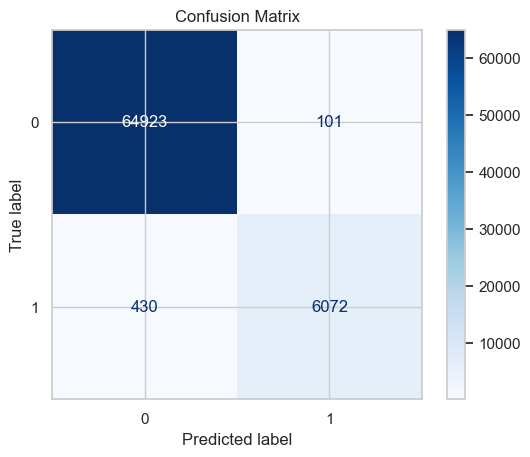

In [40]:
#visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import optuna


def objective(trial):
    # Parameter yang akan diuji
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'thread_count': -1,  # otomatis memilih jumlah thread
        'eval_metric': 'AUC',  # menggunakan AUC untuk evaluasi
        'early_stopping_rounds': 100,  # early stopping jika model tidak meningkat
        'verbose': 50 ,
        'scale_pos_weight': trial.suggest_int('scale_pos_weight',1,10),  # bobot untuk kelas positif
    }
    

    # Membuat dan melatih model
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
    
    # Evaluasi model pada validation set menggunakan Matthews Correlation Coefficient (MCC)
    y_val_pred = model.predict(X_valid)
    mcc = matthews_corrcoef(y_valid, y_val_pred)
    
    return mcc  # Kembalikan nilai MCC sebagai tujuan optimasi

# Membuat study Optuna dan menjalankan pencarian parameter terbaik
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Menjalankan 50 percobaan

# Menampilkan hasil terbaik
print(f"Best trial: {study.best_trial.params}")
print(f"Best MCC score: {study.best_value}")

[I 2025-04-24 19:32:57,806] A new study created in memory with name: no-name-6d526a36-d66d-45d7-8ba4-59a47c2962de


0:	test: 0.9503702	best: 0.9503702 (0)	total: 47.2ms	remaining: 20.8s
50:	test: 0.9903296	best: 0.9903296 (50)	total: 2.13s	remaining: 16.3s
100:	test: 0.9941201	best: 0.9941201 (100)	total: 3.99s	remaining: 13.4s
150:	test: 0.9952016	best: 0.9952016 (150)	total: 5.83s	remaining: 11.2s
200:	test: 0.9959468	best: 0.9959468 (200)	total: 7.69s	remaining: 9.18s
250:	test: 0.9963719	best: 0.9963719 (250)	total: 9.48s	remaining: 7.17s
300:	test: 0.9966377	best: 0.9966377 (300)	total: 11.4s	remaining: 5.28s
350:	test: 0.9968491	best: 0.9968491 (350)	total: 13.4s	remaining: 3.44s
400:	test: 0.9970442	best: 0.9970442 (400)	total: 15.4s	remaining: 1.53s


[I 2025-04-24 19:33:14,991] Trial 0 finished with value: 0.880022210393721 and parameters: {'iterations': 441, 'learning_rate': 0.09952273515559897, 'depth': 5, 'l2_leaf_reg': 0.006074298559093929, 'border_count': 123, 'scale_pos_weight': 10}. Best is trial 0 with value: 0.880022210393721.


440:	test: 0.9971860	best: 0.9971860 (440)	total: 16.9s	remaining: 0us

bestTest = 0.9971860022
bestIteration = 440

0:	test: 0.9354933	best: 0.9354933 (0)	total: 35.9ms	remaining: 7.75s
50:	test: 0.9708802	best: 0.9708802 (50)	total: 1.76s	remaining: 5.74s
100:	test: 0.9781582	best: 0.9781582 (100)	total: 3.51s	remaining: 4.03s
150:	test: 0.9832496	best: 0.9832496 (150)	total: 5.41s	remaining: 2.37s
200:	test: 0.9852357	best: 0.9852357 (200)	total: 7.14s	remaining: 569ms


[I 2025-04-24 19:33:22,930] Trial 1 finished with value: 0.7765665381521346 and parameters: {'iterations': 217, 'learning_rate': 0.021044111241224888, 'depth': 4, 'l2_leaf_reg': 6.145468511047098, 'border_count': 41, 'scale_pos_weight': 5}. Best is trial 0 with value: 0.880022210393721.


216:	test: 0.9857424	best: 0.9857424 (216)	total: 7.69s	remaining: 0us

bestTest = 0.9857423571
bestIteration = 216

0:	test: 0.9528808	best: 0.9528808 (0)	total: 38.8ms	remaining: 28.6s
50:	test: 0.9838622	best: 0.9838622 (50)	total: 1.86s	remaining: 25.1s
100:	test: 0.9893802	best: 0.9893802 (100)	total: 3.84s	remaining: 24.2s
150:	test: 0.9924390	best: 0.9924390 (150)	total: 5.99s	remaining: 23.3s
200:	test: 0.9937413	best: 0.9937413 (200)	total: 8.1s	remaining: 21.6s
250:	test: 0.9946840	best: 0.9946840 (250)	total: 10.2s	remaining: 19.8s
300:	test: 0.9951835	best: 0.9951835 (300)	total: 12.3s	remaining: 17.9s
350:	test: 0.9955199	best: 0.9955199 (350)	total: 14.4s	remaining: 15.9s
400:	test: 0.9959067	best: 0.9959067 (400)	total: 16.3s	remaining: 13.7s
450:	test: 0.9961278	best: 0.9961278 (450)	total: 18.2s	remaining: 11.6s
500:	test: 0.9963103	best: 0.9963103 (500)	total: 20.3s	remaining: 9.59s
550:	test: 0.9964693	best: 0.9964693 (550)	total: 22.2s	remaining: 7.53s
600:	test: 0.

[I 2025-04-24 19:33:52,515] Trial 2 finished with value: 0.8864428446458076 and parameters: {'iterations': 738, 'learning_rate': 0.04766941813198906, 'depth': 5, 'l2_leaf_reg': 0.006157456409644593, 'border_count': 218, 'scale_pos_weight': 8}. Best is trial 2 with value: 0.8864428446458076.


737:	test: 0.9968905	best: 0.9968905 (737)	total: 29.2s	remaining: 0us

bestTest = 0.9968904958
bestIteration = 737

0:	test: 0.9636094	best: 0.9636094 (0)	total: 57.4ms	remaining: 28.9s
50:	test: 0.9962865	best: 0.9962865 (50)	total: 3.2s	remaining: 28.5s
100:	test: 0.9979651	best: 0.9979651 (100)	total: 6.12s	remaining: 24.5s


Training has stopped (degenerate solution on iteration 122, probably too small l2-regularization, try to increase it)
[I 2025-04-24 19:34:00,140] Trial 3 finished with value: 0.8944090793143358 and parameters: {'iterations': 505, 'learning_rate': 0.19357381991627415, 'depth': 9, 'l2_leaf_reg': 0.0018349898164747621, 'border_count': 177, 'scale_pos_weight': 9}. Best is trial 3 with value: 0.8944090793143358.



bestTest = 0.9980943943
bestIteration = 111

Shrink model to first 112 iterations.
0:	test: 0.9588214	best: 0.9588214 (0)	total: 33.3ms	remaining: 4.39s
50:	test: 0.9721306	best: 0.9721306 (50)	total: 1.71s	remaining: 2.75s
100:	test: 0.9757495	best: 0.9757495 (100)	total: 3.37s	remaining: 1.07s


[I 2025-04-24 19:34:04,787] Trial 4 finished with value: 0.6993261695970773 and parameters: {'iterations': 133, 'learning_rate': 0.015192053380572428, 'depth': 6, 'l2_leaf_reg': 0.0048602894549030435, 'border_count': 53, 'scale_pos_weight': 8}. Best is trial 3 with value: 0.8944090793143358.


132:	test: 0.9771966	best: 0.9772075 (131)	total: 4.41s	remaining: 0us

bestTest = 0.9772074799
bestIteration = 131

Shrink model to first 132 iterations.
0:	test: 0.9540472	best: 0.9540472 (0)	total: 37.1ms	remaining: 26.4s
50:	test: 0.9700925	best: 0.9700925 (50)	total: 1.87s	remaining: 24.2s
100:	test: 0.9732423	best: 0.9732423 (100)	total: 3.72s	remaining: 22.5s
150:	test: 0.9778043	best: 0.9778043 (150)	total: 5.56s	remaining: 20.7s
200:	test: 0.9813816	best: 0.9813816 (200)	total: 7.41s	remaining: 18.8s


In [ ]:
study.best_trial.params

{'iterations': 985,
 'learning_rate': 0.14966637572713873,
 'depth': 10,
 'l2_leaf_reg': 0.029795951746300123,
 'border_count': 125,
 'scale_pos_weight': 7}

In [ ]:
#train mdoel using best params
best_params = study.best_trial.params

model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
y_pred = model.predict(X_valid)
y_pred_prob = model.predict_proba(X_valid)[:, 1]
mcc = matthews_corrcoef(y_valid, y_pred)
print(f"\n🔍 Best MCC Score: {mcc:.4f}")
print(f"Best params: {best_params}")

0:	learn: 0.4797691	test: 0.4803646	best: 0.4803646 (0)	total: 85.5ms	remaining: 1m 24s
1:	learn: 0.3616275	test: 0.3627246	best: 0.3627246 (1)	total: 165ms	remaining: 1m 20s
2:	learn: 0.2933653	test: 0.2951204	best: 0.2951204 (2)	total: 243ms	remaining: 1m 19s
3:	learn: 0.2536841	test: 0.2557038	best: 0.2557038 (3)	total: 314ms	remaining: 1m 16s
4:	learn: 0.2240593	test: 0.2259544	best: 0.2259544 (4)	total: 394ms	remaining: 1m 17s
5:	learn: 0.2022325	test: 0.2031278	best: 0.2031278 (5)	total: 472ms	remaining: 1m 17s
6:	learn: 0.1834154	test: 0.1838435	best: 0.1838435 (6)	total: 568ms	remaining: 1m 19s
7:	learn: 0.1708954	test: 0.1714905	best: 0.1714905 (7)	total: 671ms	remaining: 1m 21s
8:	learn: 0.1558499	test: 0.1558010	best: 0.1558010 (8)	total: 757ms	remaining: 1m 22s
9:	learn: 0.1440712	test: 0.1438652	best: 0.1438652 (9)	total: 842ms	remaining: 1m 22s
10:	learn: 0.1387646	test: 0.1383056	best: 0.1383056 (10)	total: 959ms	remaining: 1m 24s
11:	learn: 0.1338287	test: 0.1332392	bes

In [ ]:
X_test = test_features_df

model_pred = model.predict(X_test)
pred = (model_pred > 0.5).astype(int)

submission = pd.DataFrame({
    'id': test_df['id'].values,
    'is_referenced': pred
})
submission = submission.sort_values('id')

time_stamp = time.strftime("%Y%m%d-%H%M%S")
submission_file = f'ini ya.csv'
print(f"submission file created with {submission['is_referenced'].sum()} positive predictions "
      f"({submission['is_referenced'].mean()*100:.2f}% of test set)")


submission file created with 3847 positive predictions (1.14% of test set)


In [ ]:
submission.head()

,id,is_referenced
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
submission.to_csv(submission_file, index=False)

In [ ]:
#save model
model.save_model('catboost_model.cbm')

#save scaled_df
scaled_df.to_csv('train_features.csv', index=False)

#save test_features_df
test_features_df.to_csv('test_features.csv', index=False)